# Problem Formulation

The problem at hand is to predict if a given chemical compound is positive against non-small cell lung cancer or negative. The input to the model is a graph representation of chemical compounds, with ataoms representing nodes and bonds as edges. There are 25024 training graphs and 12326 testing graphs. 

The output of the model is a discrete prediction whether the 
chemical compound is positive(1) against non-small cell lung cancer or negative(0). This a classification problem and the required data mining function.

The main challenge presented by this problem is dealing with the imbalance in the dataset. Additionally, I have not delt with graph data or GNN before making this problem extra challenging. 

The impact of this problem, is to help doctors better diagnosis chemical compounds that are  positive against non-small cell lung cancer. In hopes of producing a model that can be generalizable to other medical conditions. 

The ideal solution to this problem is a model that can correctly predict if a chemical compound is positive against non-small cell lung cancer. The model should maintain a high AUC score as for this applicaiton detecting a positive chemical compound is more important than detecting a negative chemical compound. AUC is the probability that a model classifies a random positive example more highly than a random negative example. 


## Read SDF format data (structured-data format)

In [1]:
!pip install --quiet networkx

In [2]:
!pip install --quiet tf2_gnn

     |████████████████████████████████| 54 kB 1.1 MB/s 
     |████████████████████████████████| 73 kB 682 kB/s 
     |████████████████████████████████| 1.3 MB 8.4 MB/s 
     |████████████████████████████████| 135 kB 12.5 MB/s 
     |████████████████████████████████| 383 kB 21.4 MB/s 
     |████████████████████████████████| 90 kB 489 kB/s 
     |████████████████████████████████| 172 kB 6.3 MB/s 
     |████████████████████████████████| 4.0 MB 30.4 MB/s 
     |████████████████████████████████| 85 kB 1.8 MB/s 
     |████████████████████████████████| 41 kB 92 kB/s 


In [3]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.gnn import GNN, GNNInput
import math
import pandas as pd 
from sklearn.utils import resample


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [6]:
training_set = read_sdf('/content/gdrive/MyDrive/CISC_873_ASSIGNMETNS/CISC_873_AS6/train.sdf')
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [7]:
testing_set  = read_sdf('/content/gdrive/MyDrive/CISC_873_ASSIGNMETNS/CISC_873_AS6/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

# Walkthrough

## Visualizing/Inspecting a Sample

In [8]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [9]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

In [ ]:
training_set[10] # list of nodes and the type of atom, array of paired values, [0,5] , nodes index 0 conects to node index 5, the ground truth of the compound -> either 0 or 1

(['O',
  'O',
  'O',
  'N',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C'],
 array([[ 0,  5],
        [ 1, 10],
        [ 1, 20],
        [ 2, 12],
        [ 2, 21],
        [ 3,  4],
        [ 3, 14],
        [ 4,  5],
        [ 4,  6],
        [ 5,  8],
        [ 6,  7],
        [ 6,  9],
        [ 7, 11],
        [ 7, 13],
        [ 8, 15],
        [ 8, 16],
        [ 9, 10],
        [10, 12],
        [11, 12],
        [13, 14],
        [15, 17],
        [16, 18],
        [17, 19],
        [18, 19]]),
 0)

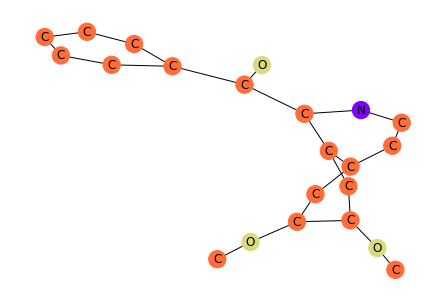

In [ ]:
plt.clf()
visualize(training_set[10])

## Preprocessing:

In [10]:
max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [11]:
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [12]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[7 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 5 5 2 2 2 3
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0  14]
 [  1   7]
 [  2   8]
 [  3  10]
 [  4   6]
 [  4  12]
 [  5   7]
 [  5   8]
 [  5  11]
 [  6   7]
 [  6   9]
 [  8  10]
 [  9  10]
 [  9  13]
 [ 11  15]
 [ 11  17]
 [ 12  14]
 [ 12  16]
 [ 14  18]
 [ 15  20]
 [ 16  19]
 [ 18  21]
 [ 19  21]
 [ 20  22]
 [ 22  23]
 [ 23  24]
 [ 23  25]
 [ 31  42]
 [ 32  51]
 [ 33  36]
 [ 34  38]
 [ 35  45]
 [ 36  39]
 [ 36  41]
 [ 37  40]
 [ 37  41]
 [ 38  42]
 [ 38  45]
 [ 39  40]
 [ 39  43]
 [ 39  44]
 [ 40  42]
 [ 41  46]
 [ 41  47]
 [ 45  48]
 [ 48  49]
 [ 48  50]
 [ 49  52]
 [ 50  53]
 [ 51  52]
 [ 51  53]
 [ 62  67]
 [ 63  68]
 [ 64  69]
 [ 65  74]
 [ 66  67]
 [ 66  68]
 [ 66  69]
 [ 67  70]
 [ 68  71]
 [ 69  72]
 [ 70  73]
 [ 71  73]
 [ 72  74]
 [ 74  75]
 [ 75  76]
 [ 76  77]

In [ ]:
# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

In [13]:

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

# 'message_calculation_class': 'rgcn' 
# params['message_calculation_class'] = 'rgcn'  by defualt

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [33]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [ ]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)



Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 31s 21ms/step - loss: 0.2248 - auc: 0.4964 - acc: 0.9513 - val_loss: 0.2139 - val_auc: 0.5821 - val_acc: 0.9499
Epoch 2/20
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1974 - auc: 0.6220 - acc: 0.9516 - val_loss: 0.1949 - val_auc: 0.6553 - val_acc: 0.9497
Epoch 3/20
1330/1330 [==============================] - 27s 21ms/step - loss: 0.1912 - auc: 0.6520 - acc: 0.9516 - val_loss: 0.1888 - val_auc: 0.6908 - val_acc: 0.9502
Epoch 4/20
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1902 - auc: 0.6621 - acc: 0.9516 - val_loss: 0.1839 - val_auc: 0.7081 - val_acc: 0.9507
Epoch 5/20
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1857 - auc: 0.6902 - acc: 0.9516 - val_loss: 0.1931 - val_auc: 0.7085 - val_acc: 0.9499
Epoch 6/20
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1882 - auc: 0.6856 - acc: 0.9516 - val_loss: 0.1833 - val_auc: 0.7194 - val_acc: 0.9505
Epo

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 6s 8ms/step


# Trial 1
 
reason for change?

In trial 0 (the walkthrough) the default message passing mechanism is a RGCN. RGCN's deal with relational graphs, where edges represent relationships between the nodes. The dataset used in this assignment does not include relational graphs, it may be that the RGCN model is having trouble handling non-relational graphs. In this trial a GGNN will be used. GGNN's use the math within GRU's for updateing it's hidden states. GGNN's extend GRNNs Graph recurrent neural networks which use graph based regularizers and better handle unknown neighborhood sizes when aggragating. GGNNs perform better than GRNNs with the graphs contain long-term dependencies. If the given chemical compounds are extra large the GGNN could help detemrine far spreading dependencies within the compound. 

expected outcome?

Without knowing the exact extent of how large the given chemical compounds are, the affect of a GRU is unknown. 

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'ggnn'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_ggnn = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_ggnn.summary()

message passing mechanism :  ggnn
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_9'), name='input_9', description="created by layer 'input_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model_ggnn.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [ ]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_ggnn.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tenso

1330/1330 [==============================] - 43s 29ms/step - loss: 0.1924 - auc: 0.6151 - acc: 0.9513 - val_loss: 0.1886 - val_auc: 0.6537 - val_acc: 0.9499
Epoch 2/20
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1867 - auc: 0.6378 - acc: 0.9516 - val_loss: 0.1906 - val_auc: 0.6728 - val_acc: 0.9494
Epoch 3/20
1330/1330 [==============================] - 41s 30ms/step - loss: 0.1867 - auc: 0.6443 - acc: 0.9516 - val_loss: 0.1852 - val_auc: 0.6917 - val_acc: 0.9502
Epoch 4/20
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1852 - auc: 0.6566 - acc: 0.9516 - val_loss: 0.1872 - val_auc: 0.6874 - val_acc: 0.9494
Epoch 5/20
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1831 - auc: 0.6675 - acc: 0.9516 - val_loss: 0.1921 - val_auc: 0.6560 - val_acc: 0.9510
Epoch 6/20
1330/1330 [==============================] - 42s 32ms/step - loss: 0.1784 - auc: 0.6993 - acc: 0.9512 - val_loss: 0.1739 - val_auc: 0.7557 - val_acc: 0.9505
Epo

###thoughts and observations for trial 1

Trial 0 
*   Train acc:  0.9515
*   Train auc: 0.6272
*   Val acc: 0.9536
*   Val auc: 0.6549
*   Test acc: 0.7185

Trial 1
*   Train acc: 0.9514
*   Train auc: 0.7609
*   Val acc: 0.9507
*   Val auc: 0.7969
*   Test acc: 0.7641


As seen the GGNN performs better than the RGCN, meaning there are long term dependencies present within the data that the GGNN was able to better model. There is some observed, overfitting with a lower test accuracy compared to the train and validation accuracies. 

###plan for trial 2

To address the overfitting observed in trail 1 I will apply up-sampling to the training set. The cause of overfitting may be due to the imbalance in the dataset, up-sampling will increase the number of data samples from the minority class


# Trial 2
 
reason for change?

In trail 1 we observed overfitting, the given dataset is imbalanced which may be the cause of the overfitting. If the model is being trained on a skewed dataset it will have toruble classifying the minority class in the test set, as it has not seen many instances of this class. The dataset has a majority class of chemical compound that are positive(1) against non-small cell lung cancer and a minority class of negative(0). Up-sampling simply copies records from the minority classes back into the training set. The up-sample funciton can be seen below, which takes in a dataset and the desired ratio of smaples between the majority and minority class. For this trial a 1:1 ratio was used, so the number of samples from each class is equal. 

expected outcome?

Up-sampling re-samples from the minoirty class creating copies of data samples, thay may cause the model to overfit to these certian duplicate data samples. The result of this trial will indicate if having a balanced dataset is effective even with the precence of duplicates. I expect this will slightly improve the overfitting issue although not significantly. 

In [13]:
def sample(set_in, sample_prc, up_down):

  np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

  tr_01 = []
  tr_00 = []

  for x in set_in:
    if (x[2] == 1):
      tr_01.append(x)
    else:
      tr_00.append(x)
  
  if up_down == False :

    n_samples = np.array(tr_00).shape[0] * sample_prc
    
    upsample = resample(tr_01,
              replace=True,
              n_samples=n_samples,
              random_state=42)
    
    up_sampled_set = upsample + tr_00
  
    print("Original Set Shape : ",np.array(set_in).shape )
    print("01 class Shape : ", np.array(tr_01).shape)
    print("00 class Shape : ", np.array(tr_00).shape)
    print("Up-Sampled 01 class Shape : ",np.array(upsample).shape)
    print("Resultant Up-Sampled Dataset : ",np.array(up_sampled_set).shape )

    return up_sampled_set

  else: 
    n_samples = np.array(tr_01).shape[0] * sample_prc
    
    downsample = resample(tr_00,
              replace=True,
              n_samples=n_samples,
              random_state=42)
    
    down_sampled_set = downsample + tr_01

    print("Original Set Shape : ",np.array(set_in).shape )
    print("01 class Shape : ", np.array(tr_01).shape)
    print("00 class Shape : ", np.array(tr_00).shape)
    print("Down-Sampled 00 class Shape : ",np.array(downsample).shape)
    print("Resultant Up-Sampled Dataset : ",np.array(down_sampled_set).shape )


    return down_sampled_set
  

In [47]:
up_sampled_training = sample(training_set, 1, False) # upsample = False

Original Set Shape :  (21270, 3)
01 class Shape :  (1033, 3)
00 class Shape :  (20237, 3)
Up-Sampled 01 class Shape :  (20237, 3)
Resultant Up-Sampled Dataset :  (40474, 3)


In [36]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'ggnn'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_ggnn_up = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_ggnn_up.summary()

message passing mechanism :  ggnn
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_9'), name='input_9', description="created by layer 'input_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                      

In [37]:
model_ggnn_up.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [40]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_ggnn_up.fit(
    gen_batch(
        up_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/10
1330/1330 [==============================] - 50s 37ms/step - loss: 0.3457 - auc: 0.9254 - acc: 0.8513 - val_loss: 0.4627 - val_auc: 0.8353 - val_acc: 0.8018
Epoch 2/10
1330/1330 [==============================] - 50s 38ms/step - loss: 0.3361 - auc: 0.9295 - acc: 0.8550 - val_loss: 0.4597 - val_auc: 0.8277 - val_acc: 0.7914
Epoch 3/10
1330/1330 [==============================] - 46s 34ms/step - loss: 0.3337 - auc: 0.9303 - acc: 0.8570 - val_loss: 0.4790 - val_auc: 0.8471 - val_acc: 0.7925
Epoch 4/10
1330/1330 [==============================] - 46s 34ms/step - loss: 0.3195 - auc: 0.9354 - acc: 0.8647 - val_loss: 0.5324 - val_auc: 0.8217 - val_acc: 0.7842
Epoch 5/10
1330/1330 [==============================] - 58s 44ms/step - loss: 0.3118 - auc: 0.9385 - acc: 0.8685 - val_loss: 0.4625 - val_auc: 0.8272 - val_acc: 0.8127
Epoch 6/10
1330/1330 [==============================] - 56s 42ms/step - loss: 0.3041 - auc: 0.9419 - acc: 0.8705 - val_loss: 0.5874 - val_auc: 0.8184 - val_acc:

###thoughts and observations for trial 2


Trial 1
*   Train acc: 0.9514
*   Train auc: 0.7609
*   Val acc: 0.9507
*   Val auc: 0.7969
*   Test acc: 0.7641

Trial 2
*   Train acc: 0.8777
*   Train auc: 0.9472
*   Val acc: 0.7930
*   Val auc: 0.8323
*   Test acc: 0.85782

These results were very promising, the overfitting is no longer present and the test accuracy was almost 10% better than trail 1. The use of up-sampling solved the issue of overfitting and gave better than expected results. The train AUC also increased from 0.7609 to 0.9472, which makes sense with the increase in samples for the positive(1) class. Again AUC is the probability that a model classifies a random positive example more highly than a random negative example. 

###plan for trial 3

Up-sampling was determined to be very benifical for overall model performance. Next down smapling the majority class will be used in an attempt to further improve model performance. 

# Trial 3
 
reason for change?

Up-sampling in trial 2 produced very promising results, as a result of rebalancing the dataset. An alternative sampling techneque is down-sampling, which samples the majority class down to the same number of occurrences in the minority class. Down-samping does not produce any duplicate data points, although the size of the training set will not be significatly less than when using up-sampling. This tiral will indicate which sampling method works better for the given problem. 

expected outcome?

Since up-sampling performed so well, it will be hard to down-sampling to produce a model that performs better. If this trial performs better than trail 2, it will be due to the lack of duplicates , while maintaing a balance in data. 

In [50]:
down_sampled_training = sample(training_set, 1, True) # down-sample = True

Original Set Shape :  (21270, 3)
01 class Shape :  (1033, 3)
00 class Shape :  (20237, 3)
Down-Sampled 00 class Shape :  (1033, 3)
Resultant Up-Sampled Dataset :  (2066, 3)


In [51]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'ggnn'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_ggnn_down = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_ggnn_down.summary()

message passing mechanism :  ggnn
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_12'), name='input_12', description="created by layer 'input_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                   

In [52]:
model_ggnn_down.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [55]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_ggnn_down.fit(
    gen_batch(
        down_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/10
1330/1330 [==============================] - 44s 33ms/step - loss: 0.4955 - auc: 0.8404 - acc: 0.7643 - val_loss: 0.5197 - val_auc: 0.8314 - val_acc: 0.7557
Epoch 2/10
1330/1330 [==============================] - 45s 34ms/step - loss: 0.4825 - auc: 0.8496 - acc: 0.7801 - val_loss: 0.4945 - val_auc: 0.8474 - val_acc: 0.7733
Epoch 3/10
1330/1330 [==============================] - 45s 34ms/step - loss: 0.4635 - auc: 0.8625 - acc: 0.7922 - val_loss: 0.6055 - val_auc: 0.8435 - val_acc: 0.7307
Epoch 4/10
1330/1330 [==============================] - 44s 33ms/step - loss: 0.4398 - auc: 0.8776 - acc: 0.8043 - val_loss: 0.4792 - val_auc: 0.8665 - val_acc: 0.7938
Epoch 5/10
1330/1330 [==============================] - 49s 37ms/step - loss: 0.4218 - auc: 0.8883 - acc: 0.8133 - val_loss: 0.5510 - val_auc: 0.8327 - val_acc: 0.7560
Epoch 6/10
1330/1330 [==============================] - 44s 33ms/step - loss: 0.4136 - auc: 0.8926 - acc: 0.8187 - val_loss: 0.6128 - val_auc: 0.8458 - val_acc:

###thoughts and observations for trial 3

Trial 2
*   Train acc: 0.8777
*   Train auc: 0.9472
*   Val acc: 0.7930
*   Val auc: 0.8323
*   Test acc: 0.85782

Trial 3
*   Train acc: 0.8375
*   Train auc: 0.9139
*   Val acc: 0.8218
*   Val auc: 0.8325
*   Test acc: 0.84735

Down-sampling resulted in very similar performance to up-sampling. It performed slightly wrose in all evaluation metrics although still better than trial 1. Since both perfomred very similar further analysis will be conducted to see their affects on other message passing mechanisums.

###plan for trial 4

RGAT will now be used as the message passing mechanisums, first with the standard dataset, with no sampling, to determine a baseline.  

# Trial 4
 
reason for change?

We saw performance improvemnts when transitioning from a RGCN in trial 0 to a GGNN in trial 1. The addition of a GRU like arcitecture allowed for the model to learn long term dependencies. 

expected outcome?

Since up-sampling performed so well, it will be hard to down-sampling to produce a model that performs better. If this trial performs better than trail 2, it will be due to the lack of duplicates , while maintaing a balance in data. 

In [17]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'rgat'
params["num_heads"] = 4
print(params)
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_RGAT = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_RGAT.summary()

{'aggregation_function': 'sum', 'message_activation_function': 'relu', 'message_activation_before_aggregation': False, 'hidden_dim': 32, 'use_target_state_as_input': False, 'normalize_by_num_incoming': True, 'num_edge_MLP_hidden_layers': 0, 'message_calculation_class': 'rgat', 'initial_node_representation_activation': 'tanh', 'dense_intermediate_layer_activation': 'tanh', 'num_layers': 4, 'dense_every_num_layers': 2, 'residual_every_num_layers': 2, 'use_inter_layer_layernorm': False, 'layer_input_dropout_rate': 0.0, 'global_exchange_mode': 'gru', 'global_exchange_every_num_layers': 2, 'global_exchange_weighting_fun': 'softmax', 'global_exchange_num_heads': 4, 'global_exchange_dropout_rate': 0.2, 'num_heads': 4}
message passing mechanism :  rgat
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, n

In [18]:
model_RGAT.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [21]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_RGAT.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1330/1330 [==============================] - 25s 18ms/step - loss: 0.1815 - auc: 0.7055 - acc: 0.9515 - val_loss: 0.1890 - val_auc: 0.7139 - val_acc: 0.9486
Epoch 2/10
1330/1330 [==============================] - 22s 17ms/step - loss: 0.1810 - auc: 0.7097 - acc: 0.9514 - val_loss: 0.1788 - val_auc: 0.7238 - val_acc: 0.9523
Epoch 3/10
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1790 - auc: 0.7191 - acc: 0.9514 - val_loss: 0.1959 - val_auc: 0.6854 - val_acc: 0.9489
Epoch 4/10
1330/1330 [==============================] - 22s 17ms/step - loss: 0.1791 - auc: 0.7143 - acc: 0.9516 - val_loss: 0.1896 - val_auc: 0.6875 - val_acc: 0.9483
Epoch 5/10
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1805 - auc: 0.7089 - acc: 0.9516 - val_loss: 0.1873 - val_auc: 0.6858 - val_acc: 0.9502
Epoch 6/10
1330/1330 [==============================] - 22s 17ms/step - loss: 0.1802 - auc: 0.7100 - acc: 0.9518 - val_loss: 0.1842 - val_auc: 0.7015 - val_acc:

###thoughts and observations for trial 4

Trial 1
*   Train acc: 0.9514
*   Train auc: 0.7609
*   Val acc: 0.9507
*   Val auc: 0.7969
*   Test acc: 0.7641

Trial 4
*   Train acc: 0.9516
*   Train auc: 0.7042
*   Val acc: 0.9529
*   Val auc: 0.6091
*   Test acc: 0.6085

Comparing trial 4 to trial 1 will give better analysis as both trials did not use any sampling technequies. The standard GGNN outperforms the RGAT message passing mechanism with no sampling technequies applied. The addition of an attension mechanism may have over exaggerated the overfitting issue. The model may be applying attention heavily in favour of the majority class, casuing further overfitting. 

###plan for trial 5

The next two trials will explore the affects up sampling and down sampling have on the RGAT message passing mechanism. First upsampling will be applied in trial 5

# Trial 5
 
reason for change?

In trail 1 and trial 4 we observed overfitting, although after applying sampling technequies in trial 2 and 3 the overfitting issue disappeared. The sampaling function can be seen above in trial 2. The same up-sampling as seen in trial 2 will now be applied in this trail. For this trial a 1:1 ratio was used, so the number of samples from each class is equal. 

expected outcome?

As seen in trial 2 up-sampling worked wonders, to both fix the overfitting issue and improve overall accuracy. I believe the RGAT message passing mechanism will be able to better apply its attension mechanism to a balanced dataset. Thus outperforming the results found in trial 2. 

In [25]:
up_sampled_training = sample(training_set, 1, False) # upsample = False

Original Set Shape :  (21270, 3)
01 class Shape :  (1032, 3)
00 class Shape :  (20238, 3)
Up-Sampled 01 class Shape :  (20238, 3)
Resultant Up-Sampled Dataset :  (40476, 3)


In [26]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'rgat'
params["num_heads"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_rgat_up = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_rgat_up.summary()

message passing mechanism :  rgat
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_18'), name='input_18', description="created by layer 'input_18'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                   

In [27]:
model_rgat_up.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [28]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_rgat_up.fit(
    gen_batch(
        up_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/

1330/1330 [==============================] - 36s 24ms/step - loss: 0.6362 - auc: 0.6931 - acc: 0.6414 - val_loss: 0.8276 - val_auc: 0.6609 - val_acc: 0.5802
Epoch 2/10
1330/1330 [==============================] - 30s 23ms/step - loss: 0.6011 - auc: 0.7412 - acc: 0.6881 - val_loss: 0.5942 - val_auc: 0.6745 - val_acc: 0.7363
Epoch 3/10
1330/1330 [==============================] - 31s 23ms/step - loss: 0.5933 - auc: 0.7493 - acc: 0.7008 - val_loss: 0.7242 - val_auc: 0.7064 - val_acc: 0.6177
Epoch 4/10
1330/1330 [==============================] - 29s 22ms/step - loss: 0.5859 - auc: 0.7576 - acc: 0.7011 - val_loss: 0.6429 - val_auc: 0.7236 - val_acc: 0.7251
Epoch 5/10
1330/1330 [==============================] - 33s 25ms/step - loss: 0.5698 - auc: 0.7792 - acc: 0.7153 - val_loss: 0.7209 - val_auc: 0.7274 - val_acc: 0.6558
Epoch 6/10
1330/1330 [==============================] - 29s 22ms/step - loss: 0.5587 - auc: 0.7906 - acc: 0.7207 - val_loss: 0.6592 - val_auc: 0.7376 - val_acc: 0.7147
Epo

###thoughts and observations for trial 5

Trial 2
*   Train acc: 0.8777
*   Train auc: 0.9472
*   Val acc: 0.7930
*   Val auc: 0.8323
*   Test acc: 0.85782

Trial 5
*   Train acc: 0.7527
*   Train auc: 0.8281
*   Val acc: 0.6606
*   Val auc: 0.7528
*   Test acc: 0.80155

Comparing trial 5 to trial 2 will give better analysis as both trials did not use up-sampling technequies. The standard GGNN outperforms the RGAT message passing mechanism with up-sampling technequies applied. The attension mechanisum was able to better apply it self to a balanced dataset. I was able to acheive a 20% increase in test accuracy with the addtion of up-sampling, comparing trail 4 to trial 5. The same issue that was seen from trial 0 to trial 1, relational graph architecture models seen to perform worse than non-relational graph architectures on this dataset. The dataset includes non-realtional graphs and thus the relational models seem to perfrom worse. 

###plan for trial 6

Down-sampling will be applied to the majority class using the same RGAT message passing mechanism seem in trial 5.  

# Trial 6
 
reason for change?

Trial 3 showed that down-sampling the majority class led to slightly worse performance than compared to up-sampling in trial 2. I wil now apply down-smapling with the the RGAT message passing mechanism to see if the descrpency in performance between down-sampling and up-smapling is model specific. 

expected outcome?

I beleive that up-smapling for this problem is the better solution as it maintains a large dataset while fixing the imbalance. I do not think this is a model specific discrpency although this test will further my understanding. I think this trial will slightly underperfom compared to trail 5.

In [31]:
down_sampled_training = sample(training_set, 1, True) # down-sample = True

Original Set Shape :  (21270, 3)
01 class Shape :  (1032, 3)
00 class Shape :  (20238, 3)
Down-Sampled 00 class Shape :  (1032, 3)
Resultant Up-Sampled Dataset :  (2064, 3)


In [32]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'rgat'
params["num_heads"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_rgat_down = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_rgat_down.summary()

message passing mechanism :  rgat
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_21'), name='input_21', description="created by layer 'input_21'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                   

In [33]:
model_rgat_down.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [34]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_rgat_down.fit(
    gen_batch(
        down_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/

1330/1330 [==============================] - 40s 26ms/step - loss: 0.6335 - auc: 0.6969 - acc: 0.6422 - val_loss: 0.6232 - val_auc: 0.6673 - val_acc: 0.7464
Epoch 2/10
1330/1330 [==============================] - 39s 29ms/step - loss: 0.6001 - auc: 0.7431 - acc: 0.6917 - val_loss: 0.8018 - val_auc: 0.6951 - val_acc: 0.5730
Epoch 3/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.5896 - auc: 0.7590 - acc: 0.7055 - val_loss: 0.7405 - val_auc: 0.6824 - val_acc: 0.6417
Epoch 4/10
1330/1330 [==============================] - 36s 27ms/step - loss: 0.5762 - auc: 0.7700 - acc: 0.7117 - val_loss: 0.7299 - val_auc: 0.7068 - val_acc: 0.6518
Epoch 5/10
1330/1330 [==============================] - 38s 28ms/step - loss: 0.5698 - auc: 0.7787 - acc: 0.7172 - val_loss: 0.5689 - val_auc: 0.7024 - val_acc: 0.7629
Epoch 6/10
1330/1330 [==============================] - 37s 28ms/step - loss: 0.5572 - auc: 0.7897 - acc: 0.7234 - val_loss: 0.7344 - val_auc: 0.7064 - val_acc: 0.6734
Epo

###thoughts and observations for trial 6

Trial 5
*   Train acc: 0.7527
*   Train auc: 0.8281
*   Val acc: 0.6606
*   Val auc: 0.7528
*   Test acc: 0.80155

Trial 6
*   Train acc: 0.7495
*   Train auc: 0.8264
*   Val acc: 0.7344
*   Val auc: 0.7399
*   Test acc: 0.7701

Down-smapling again produced slightly worse test accuracy, with a 3% decrease in test accuracy compared to trial 5 (up-sampling). This is leaning towards a trend of being a worse sampling technique for this problem rather than a model specific trend. 

###plan for trial 7

For the next 3 trials the GNN-FiLM message passing mechanism will be used. Agian, sampling techniques will be applied to determine their affects on this specific model.  

# Trial 7
 
reason for change?

GNN-FiLM, implements a feature-wise linear modulation (FiLM). Standard GNN message passing mechanisms compute messages only with the representation of the source node. With GNN-FiLM the target node is also included in the computation, allowing for feature-wise modeulation. Computations/transofmraitons that are applied to each feature independently. GNN-FiLM again works with relational graphs. This arcitecture is newer than previously used message passing mechanisms in earlier trials. Since this model is more recently published the ideas behind it, build on models seen in previous trials. 

expected outcome?

This model is more recently published so it may result in better performance. Again this model was created for relational graphs, as we saw in trial 4-6 with the use of RGAT these models do not perform as well as non relational GNNs. As this dataset does not include relational graphs.

In [46]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'gnn_film'
params["film_parameter_MLP_hidden_layers"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_GNN_FiLM = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_GNN_FiLM.summary()

message passing mechanism :  gnn_film
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_36'), name='input_36', description="created by layer 'input_36'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []             

In [47]:
model_GNN_FiLM.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [48]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_GNN_FiLM.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/py

1330/1330 [==============================] - 59s 31ms/step - loss: 0.2202 - auc: 0.5309 - acc: 0.9508 - val_loss: 0.1985 - val_auc: 0.5803 - val_acc: 0.9505
Epoch 2/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.2012 - auc: 0.6308 - acc: 0.9515 - val_loss: 0.2572 - val_auc: 0.6337 - val_acc: 0.9505
Epoch 3/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1934 - auc: 0.6658 - acc: 0.9515 - val_loss: 0.1930 - val_auc: 0.6997 - val_acc: 0.9505
Epoch 4/10
1330/1330 [==============================] - 46s 35ms/step - loss: 0.1926 - auc: 0.6867 - acc: 0.9515 - val_loss: 0.2751 - val_auc: 0.6406 - val_acc: 0.9510
Epoch 5/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1967 - auc: 0.6736 - acc: 0.9515 - val_loss: 0.1833 - val_auc: 0.7373 - val_acc: 0.9494
Epoch 6/10
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1882 - auc: 0.6991 - acc: 0.9515 - val_loss: 0.2465 - val_auc: 0.6993 - val_acc: 0.9507
Epo

###thoughts and observations for trial 7

Trial 1
*   Test acc: 0.7641

Trial 4
*   Train acc: 0.9516
*   Train auc: 0.7042
*   Val acc: 0.9529
*   Val auc: 0.6091
*   Test acc: 0.6085

Trial 7
*   Train acc: 0.9515
*   Train auc: 0.6675
*   Val acc: 0.9521
*   Val auc: 0.6397
*   Test acc: 0.65063

Again compared to trial 1, the test accuracy is 10% worse, although comapring to trial 4 where RGAT was used there is a 5% increase. Comparing to the other relational graph arcitecture the slight imporovment is promising. Applying sampling techneques will increase the performance, but by how much we will have to see. 

###plan for trial 8

Down-sampling will be applied to the majority class using the same GNN-FiLM message passing mechanism seem in trial 7.  

# Trial 8
 
reason for change?

In trail 1,4, and 7 we observed overfitting, although after applying sampling technequies in trial 2 and 3 the overfitting issue disappeared. The sampaling function can be seen above in trial 2. The same up-sampling as seen in trial 2 will now be applied in this trail. For this trial a 1:1 ratio was used, so the number of samples from each class is equal. 

expected outcome?

As seen in previous trials up-sampling worked wonders, to both fix the overfitting issue and improve overall accuracy. I believe the GNN-FiLM message passing mechanism will perform better than the RGAT model, as it had better baseline performance without any smapling.

In [51]:
up_sampled_training = sample(training_set, 1, False) # upsample = False

Original Set Shape :  (21270, 3)
01 class Shape :  (1032, 3)
00 class Shape :  (20238, 3)
Up-Sampled 01 class Shape :  (20238, 3)
Resultant Up-Sampled Dataset :  (40476, 3)


In [55]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'gnn_film'
params["film_parameter_MLP_hidden_layers"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_GNN_FiLM_up = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_GNN_FiLM_up.summary()

message passing mechanism :  gnn_film
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_42'), name='input_42', description="created by layer 'input_42'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []             

In [56]:
model_GNN_FiLM_up.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [59]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_GNN_FiLM_up.fit(
    gen_batch(
        up_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1330/1330 [==============================] - 46s 35ms/step - loss: 0.5139 - auc: 0.8336 - acc: 0.7614 - val_loss: 0.5296 - val_auc: 0.7985 - val_acc: 0.7555
Epoch 2/10
1330/1330 [==============================] - 53s 40ms/step - loss: 0.4918 - auc: 0.8490 - acc: 0.7774 - val_loss: 0.6301 - val_auc: 0.7813 - val_acc: 0.7112
Epoch 3/10
1330/1330 [==============================] - 46s 35ms/step - loss: 0.5135 - auc: 0.8347 - acc: 0.7628 - val_loss: 0.7083 - val_auc: 0.7643 - val_acc: 0.6723
Epoch 4/10
1330/1330 [==============================] - 46s 35ms/step - loss: 0.5533 - auc: 0.8028 - acc: 0.7303 - val_loss: 0.8267 - val_auc: 0.7848 - val_acc: 0.5461
Epoch 5/10
1330/1330 [==============================] - 49s 37ms/step - loss: 0.5116 - auc: 0.8381 - acc: 0.7671 - val_loss: 0.6685 - val_auc: 0.7726 - val_acc: 0.7072
Epoch 6/10
1330/1330 [==============================] - 47s 35ms/step - loss: 0.5895 - auc: 0.7632 - acc: 0.6977 - val_loss: 0.5879 - val_auc: 0.7317 - val_acc:

###thoughts and observations for trial 8

Trial 2
*   Test acc: 0.85782

Trial 5
*   Train acc: 0.7527
*   Train auc: 0.8281
*   Val acc: 0.6606
*   Val auc: 0.7528
*   Test acc: 0.80155

Trial 8
*   Train acc: 0.6867
*   Train auc:0.7452
*   Val acc: 0.5405
*   Val auc: 0.7075
*   Test acc: 0.75522

This was by far the worst trial where up-sampling was used. The GNN-FiLM message passing mechanism may not be the best choice for this problem.  

###plan for trial 9

Down-sampling will be applied to the majority class using the same GNN-FiLM message passing mechanism seem in trial 7.  

# Trial 9
 
reason for change?

Trial 3 and 6 showed that down-sampling the majority class led to slightly worse performance than compared to up-sampling in other trials. I wil now apply down-smapling with the the GNN-FiLM message passing mechanism to see if the descrpency in performance between down-sampling and up-smapling is model specific. 

expected outcome?

I beleive that up-smapling for this problem is the better solution as it maintains a large dataset while fixing the imbalance. I do not think this is a model specific discrpency although this test will further my understanding. I think this trial will slightly underperfom compared to trail 8.

In [60]:
down_sampled_training = sample(training_set, 1, True) # down-sample = True

Original Set Shape :  (21270, 3)
01 class Shape :  (1032, 3)
00 class Shape :  (20238, 3)
Down-Sampled 00 class Shape :  (1032, 3)
Resultant Up-Sampled Dataset :  (2064, 3)


In [63]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'gnn_film'
params["film_parameter_MLP_hidden_layers"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_GNN_FiLM_down = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_GNN_FiLM_up.summary()

message passing mechanism :  gnn_film
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_14/StatefulPartitionedCall:0', description="created by layer 'gnn_14'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_45'), name='input_45', description="created by layer 'input_45'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []             

In [64]:
model_GNN_FiLM_down.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [65]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_GNN_FiLM_down.fit(
    gen_batch(
        down_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/py

1330/1330 [==============================] - 54s 37ms/step - loss: 0.6361 - auc: 0.6931 - acc: 0.6390 - val_loss: 0.6121 - val_auc: 0.7169 - val_acc: 0.7027
Epoch 2/10
1330/1330 [==============================] - 55s 42ms/step - loss: 0.5850 - auc: 0.7659 - acc: 0.6955 - val_loss: 0.5425 - val_auc: 0.7156 - val_acc: 0.7896
Epoch 3/10
1330/1330 [==============================] - 50s 37ms/step - loss: 0.5652 - auc: 0.7851 - acc: 0.7161 - val_loss: 0.6249 - val_auc: 0.7294 - val_acc: 0.6851
Epoch 4/10
1330/1330 [==============================] - 52s 39ms/step - loss: 0.6104 - auc: 0.7302 - acc: 0.6595 - val_loss: 0.6711 - val_auc: 0.6351 - val_acc: 0.5746
Epoch 5/10
1330/1330 [==============================] - 46s 35ms/step - loss: 0.6078 - auc: 0.7412 - acc: 0.6696 - val_loss: 0.8254 - val_auc: 0.7007 - val_acc: 0.5088
Epoch 6/10
1330/1330 [==============================] - 49s 37ms/step - loss: 0.5798 - auc: 0.7727 - acc: 0.7015 - val_loss: 0.7480 - val_auc: 0.7276 - val_acc: 0.6204
Epo

###thoughts and observations for trial 9

Trial 6 (RGAT down_sample) 
*   Test acc: 0.7701

Trial 8
*   Train acc: 0.6867
*   Train auc:0.7452
*   Val acc: 0.5405
*   Val auc: 0.7075
*   Test acc: 0.75522

Trial 9
*   Train acc: 0.6738
*   Train auc:0.7091
*   Val acc: 0.6582
*   Val auc: 0.7171
*   Test acc: 0.70293

Again we see that down-sampling the majority class leads to worse performance compared to up-sampling. It can now be concluded that this is not a model specific discrpency but a applicaiton/problem discepency. 

###plan for trial 10

For the last trail we will see how the RGIN message passing mechanism performs our the problem at hand. Since it is the last trial I will apply down-sampling as it has resulted in the best performance so far. 

# Trial 10
 
reason for change?

RGIN, relational graph isomorphic networks. Isomorphic graphs are graphs which have the same number of verticices, edges, and edge connections. The RGIN message passing mechanism attempts to better handle these types of graphs. If these graphs are present in the given dataset then the model may result in better performance. 

expected outcome?

If the dataset includes isomorphic grpahs then the model should outperform the previous trials. 

In [18]:
up_sampled_training = sample(training_set, 1, False) # upsample = False

Original Set Shape :  (21270, 3)
01 class Shape :  (1021, 3)
00 class Shape :  (20249, 3)
Up-Sampled 01 class Shape :  (20249, 3)
Resultant Up-Sampled Dataset :  (40498, 3)


In [15]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGIN'
params["num_aggr_MLP_hidden_layers"] = 2
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('message passing mechanism : ',params["message_calculation_class"])

print('gnn_out', gnn_out)

print('node2graph', node2graph)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_GNN_RGIN_up = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_GNN_RGIN_up.summary()

message passing mechanism :  RGIN
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
node2graph KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int32, name='input_9'), name='input_9', description="created by layer 'input_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               


In [16]:
model_GNN_RGIN_up.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC','acc']
)

In [19]:
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_GNN_RGIN_up.fit(
    gen_batch(
        up_sampled_training, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/loca

1330/1330 [==============================] - 41s 27ms/step - loss: 0.6378 - auc: 0.6861 - acc: 0.6341 - val_loss: 0.7858 - val_auc: 0.7154 - val_acc: 0.6460
Epoch 2/10
1330/1330 [==============================] - 33s 25ms/step - loss: 0.6098 - auc: 0.7322 - acc: 0.6758 - val_loss: 0.7161 - val_auc: 0.7294 - val_acc: 0.6385
Epoch 3/10
1330/1330 [==============================] - 35s 27ms/step - loss: 0.6035 - auc: 0.7419 - acc: 0.6856 - val_loss: 0.8286 - val_auc: 0.7344 - val_acc: 0.5831
Epoch 4/10
1330/1330 [==============================] - 34s 25ms/step - loss: 0.5937 - auc: 0.7524 - acc: 0.6954 - val_loss: 0.7122 - val_auc: 0.7312 - val_acc: 0.6513
Epoch 5/10
1330/1330 [==============================] - 37s 28ms/step - loss: 0.5920 - auc: 0.7546 - acc: 0.6948 - val_loss: 0.4753 - val_auc: 0.7384 - val_acc: 0.8306
Epoch 6/10
1330/1330 [==============================] - 34s 26ms/step - loss: 0.5824 - auc: 0.7681 - acc: 0.7079 - val_loss: 0.5609 - val_auc: 0.7337 - val_acc: 0.7725
Epo

###thoughts and observations for trial 10

This trail resutled in worse performance than previous trials. In conclusion the GGNN message passing mechanisum was the best solution as it was not built for relational graphs. The other models were built for relational graphs and our dataset does not include relational graphs. In addition the up sampling technique worked better than down sampling on the given problem and was not a model specific discepency. 


# Testing

In [ ]:
print(len(testing_set))

12326


In [66]:
y_pred = model_GNN_FiLM_down.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 7s 9ms/step


In [ ]:
len(y_pred)

12326

In [67]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('model_GNN_FiLM_down.csv')

🌈Based on the provided template, describe the format of the input file (sdf file).

An sdf file is a compact relational database, in this case of this assignment the sdf file contains information on each chemical compound found in the dataset. The file contains a tabular form of data which contians the links, nodes , and label for each compound found in the dataset. This will help create the 3 inputs to the model data, edge, and node2graph, as well as the ground truths for each datapoint. 


🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

The 3 inputs to the neural network model are data, edge, and node2graph. These 3 inputs combine to make the adjacency matrix used for batch representaion. Data is a matrix representaiton of the differnt adams within the chemical compound, the names of the atoms are tokenized to make up the final vector. Data has dimensions [batch_size* max_nodes_per_graph, ]which means for the size of batch(16) multiplied by the number of nodes in a graph, this being a 1D vector. Edge is a 2D vector containing pairs of Ints, these Ints represent the connection of two atoms or nodes. The entire edge vector contains all connetions between nodes in the graph. Edge has dimensions [number_of_edges, 2], as just explained, these dimensions show all pairs(2) of edges(number_of_edges). node2graph is a matrix that represents the segment_ids used in the segment_mean layer and represents which graph in the batch each node comes from. node2graph has dimensions [batch_size* max_nodes_per_graph, ] which means for the size of batch(16) multiplied by the number of nodes in a graph, this being a 1D vector. 

🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

The dimensions of gnn_out are [batch_size*max_nodes_per_graph, 32] where 32 represents the value for "hidden_dim" which sets the size of the output of all message passing layers. "batch_size*max_nodes_per_graph" also being the dimension of node2graph. The dimensions of avg are [batch_size, 32], as said before represents the value for "hidden_dim" and batch self is self explainatory. 


🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

tf.reduce_mean, reduces the input tensor along the dimensions given as input in the function call. tf.math.segment_mean, allows you to specify segmented regions to take the mean over. segment_mean still reduces the input tensor although over the given segments rather than over a given axis. There is only one dimension of pred, and it symbolizes the predicted value for the given graph. This number will be between 0 and 1 as the pred layer implements a sigmoid fucniton. 

🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

The idea behind using multiple gcn layers corresponds to how many neighbours are considered in the final feature vector. When you use one gcn layer each node considers all of its immidate neighbroughs when aggragating. If you increase the number of layers, the second layer will now consider each nodes neighbours, neighbours when aggragating. Each added layer increases the order of informaiton you are including in your aggragation. The templete uses 1 GCN layer. 